In [40]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.integrate import solve_ivp, odeint
from scipy.optimize import minimize, curve_fit
import numpy as np

In [2]:
df = pd.read_csv("resources/train.csv")
df

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0000,65.0000,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0000,65.0000,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0000,65.0000,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0000,65.0000,2020-01-26,0.0,0.0
...,...,...,...,...,...,...,...,...
16751,26374,NaN,Zambia,-15.4167,28.2833,2020-03-16,0.0,0.0
16752,26375,NaN,Zambia,-15.4167,28.2833,2020-03-17,0.0,0.0
16753,26376,NaN,Zambia,-15.4167,28.2833,2020-03-18,2.0,0.0
16754,26377,NaN,Zambia,-15.4167,28.2833,2020-03-19,2.0,0.0


In [3]:
df.describe()

,Id,Lat,Long,ConfirmedCases,Fatalities
count,16756.000000,16697.000000,16697.000000,16756.000000,16756.000000
mean,13189.500000,26.337324,5.039603,271.750119,9.221533
std,7624.686932,22.963063,79.935267,3261.152305,141.524582
min,1.000000,-41.454500,-157.498300,0.000000,0.000000
25%,6595.250000,13.193900,-71.530100,0.000000,0.000000
50%,13189.500000,33.000000,10.000000,0.000000,0.000000
75%,19783.750000,42.506300,65.000000,7.000000,0.000000
max,26378.000000,72.000000,174.886000,67800.000000,4032.000000


In [4]:
df["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cruise Ship', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'French Guiana', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guadeloupe',
       'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'Holy See',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia

In [5]:
data = df[df["Country/Region"].isin(["China", "US", "Italy", "Spain"])]
data

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
2773,4372,Anhui,China,31.8257,117.2264,2020-01-22,1.0,0.0
2774,4373,Anhui,China,31.8257,117.2264,2020-01-23,9.0,0.0
2775,4374,Anhui,China,31.8257,117.2264,2020-01-24,15.0,0.0
2776,4375,Anhui,China,31.8257,117.2264,2020-01-25,39.0,0.0
2777,4376,Anhui,China,31.8257,117.2264,2020-01-26,60.0,0.0
...,...,...,...,...,...,...,...,...
16043,25258,Wyoming,US,42.7560,-107.3025,2020-03-16,3.0,0.0
16044,25259,Wyoming,US,42.7560,-107.3025,2020-03-17,11.0,0.0
16045,25260,Wyoming,US,42.7560,-107.3025,2020-03-18,15.0,0.0
16046,25261,Wyoming,US,42.7560,-107.3025,2020-03-19,18.0,0.0


In [6]:
data = data.groupby(["Date", 'Country/Region']).sum().reset_index()
data["Date"] = pd.to_datetime(data["Date"])


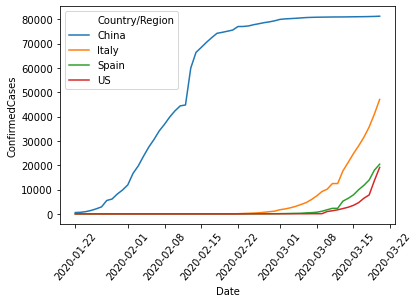

In [7]:
c = sns.lineplot(x='Date', y='ConfirmedCases', hue="Country/Region", data=data)
#c.format_xdata = mdates.DateFormatter('%Y-%m-%d')

c.xaxis.set_tick_params(rotation=50)

In [143]:
def ds_dt (beta, S, I):
    ds_dt = -1.0 * beta * I * S
    return ds_dt

def di_dt (beta, gamma, S, I):
    di_dt = 1.0 * beta * I * S - gamma * I
    return di_dt

def dr_dt (gamma, I):
    dr_dt = gamma * I
    return dr_dt

def next_sir(b, g, st, it, rt):
    delta_s = ds_dt(b, st, it)
    delta_i = di_dt(b, g, st, it)
    delta_r = dr_dt(g, it)
    st = delta_s
    it = delta_i
    rt = delta_r
    return [st, it, rt]

def sir_model(y, t, b, g):
    s, i, r = y
    return next_sir(b, g, s, i, r)

def sir_model2(t, y, b, g):
    s, i, r = y
    return next_sir(b, g, s, i, r)

In [144]:
n = 7.9*(10**2)
s0 = n-1
i0 = 1
r0 = 0
beta0 = 0.5 / n
gamma0 = 0.3

sus, inf, rec= [],[],[]
    
days = 60
s=s0
i=i0
r=r0
for d in range(days):
    s, i, r = next_day_sir(beta0, gamma0, s, i, r)
    sus.append(s)
    inf.append(i)
    rec.append(r)
    
    


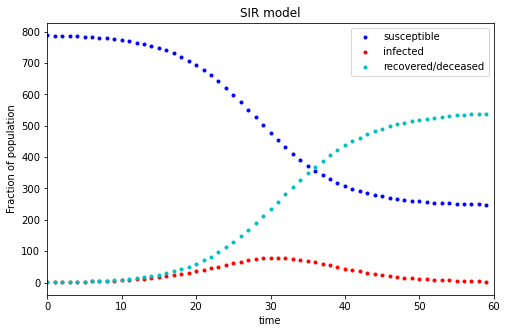

In [145]:
f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,days)
#plt.savefig('SIR_example.png')
plt.show()

248.46961188564703 789.0 3.102877074839445 1 538.4275110395133 0
[1.1993670886075949, 1.4381023471266978, 1.723813314746653, 2.0655046942670667, 2.4738028254948077, 2.9612017306260627, 3.5423256152308946, 4.2341981640093165, 5.056502404722709, 6.031805718211281, 7.1857120988162295, 8.546887446467146, 10.14688323205888, 12.019659752578665, 14.200684132740946, 16.725454196743414, 19.627284620958523, 22.934198154151655, 26.664809020443247, 30.82318893580783, 35.3928896311473, 40.330571705836334, 45.560046664315124, 50.96792325863967, 56.40234932414556, 61.67639042037092, 66.5772065429385, 70.88126815425375, 74.37446316827146, 76.87441140907434, 78.2511562298045, 78.4421867182719, 77.4587200205644, 75.38212063404879, 72.35159663282101, 68.54610764099016, 64.16421035958808, 59.40527886230361, 54.454496309030844, 49.472717023697925, 44.59116416540851, 39.91018093947489, 35.50091983422847, 31.40884177365265, 27.65807402334866, 24.255926898197377, 21.197117424595987, 18.467453280988142, 16.046

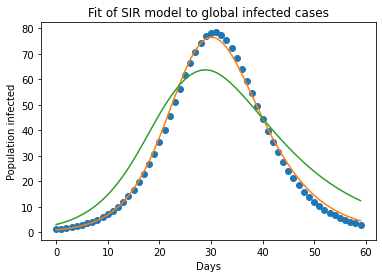

Optimal parameters: beta = 7.810018670592745e-07  and gamma =  0.28993513496788437
[0.00108592 0.10545842]


In [148]:
xdata = np.arange(days)
ydata = inf



def sumsq(p):
    beta, gamma = p
    sol = solve_ivp(sir_model2,[0,days],[s, i, r],t_eval=xdata, args=(beta, gamma))
    return(sum((sol.y[1]-ydata)**2))

def fit_odeint(x, betax, gammax):
    return odeint(sir_model, (s0, i0, r0), x, args=(betax, gammax))[:,1]

print(s,s0,i,i0,r,r0)
print(ydata)
popt, pcov = curve_fit(fit_odeint, xdata, ydata, p0=(beta0, gamma0))
fitted = fit_odeint(xdata, *popt)
msol = minimize(sumsq,[beta0, gamma0],tol=1e-5)
sol = solve_ivp(sir_model2,[0,days],[s, i, r],t_eval=xdata, args=msol.x)

#print(sum((sol.y[1]-ydata)**2))

plt.plot(xdata, ydata, 'o', label="simulated")
plt.plot(xdata, fitted, label='curve fit')
plt.plot(sol.t, sol.y[1], label='sol')
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0]/n, " and gamma = ", popt[1])
print(msol.x)

In [62]:
np.arange(14)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])